# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [ ]:
%pip install optuna==3.6.1

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

In [3]:
base_path = 'C:/Users/pedro/Documents/DMEyF/dmeyf2025/'
dataset_path = base_path + 'data/processed/'
modelos_path = base_path + 'models/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'

ganancia_acierto = 780000
costo_estimulo = 20000

mes_train = 202102
mes_test = 202104

# agregue sus semillas
semillas = [17,19,23,29,31]

data = pd.read_csv(dataset_path + dataset_file)

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [4]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

Además, como se mencionó en la clase pasada, comenzaremos a experimentar con nuevas clases para ajustar el modelo. En particular, sumaremos la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [5]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

In [6]:
train_data = data[data['foto_mes'] == mes_train]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

Y preparamos el *dataset* para poder usar el **rf** de una clase anterior.

In [7]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
Xif = imp_mean.fit_transform(X_test)

Comenzaremos explicando el funcionamiento del protagonista de esta clase: **LightGBM**. Primero, partiremos con una revisión de cómo funciona el algoritmo en el que se basa, **XGBoost**. Para una introducción completa, puedes consultar este

https://xgboost.readthedocs.io/en/stable/tutorials/model.html.

Aunque en la cátedra no somos grandes seguidores de Josh Starmer y su canal *StatQuest*, reconozco que sus series sobre *Gradient Boosting* y *XGBoost* son excelentes recursos. Aquí te dejamos los enlaces a esas dos series que realmente valen la pena:

[Serie Gradient Boosting](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

[Serie XGBoost](https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ)

Finalmente, analizaremos las diferencias clave que ofrece **LightGBM** frente a XGBoost. Puedes explorar más sobre ello en este https://lightgbm.readthedocs.io/en/stable/Features.html.

No olvides tener a mano la [documentación de LightGBM](https://lightgbm.readthedocs.io/)y la [lista completa de sus parámetros](https://lightgbm.readthedocs.io/en/latest/Parameters.html).

Este es un algoritmo muy usado en el mercado, recomiendo dedicarle el tiempo necesario para aprenderlo bien.

Vamos a utilizar el algoritmo directamente, sin pasar por *scikit-learn*. Sin embargo, si algún alumno lo prefiere, puede optar por usar el *wrapper* de sklearn para este caso.

Para evaluar la calidad del modelo, crearemos nuestra propia función de evaluación que calcule la ganancia. La razón de incluir los pesos es precisamente para poder implementar esta función de evaluación de manera adecuada. Al combinar las clases *BAJA+1* y *BAJA+2* en una sola, necesitamos una forma de diferenciarlas, y es aquí donde entra en juego el *weight*. Este parámetro nos permitirá distinguir entre ambas clases al momento de evaluarlas dentro del algoritmo.


In [8]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

LGBM necesita su propio tipo de Datasets:

In [ ]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv** que viene *out-of-the-box*

In [10]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

Y vizualizamos los resultados de ambas ejecuciones:

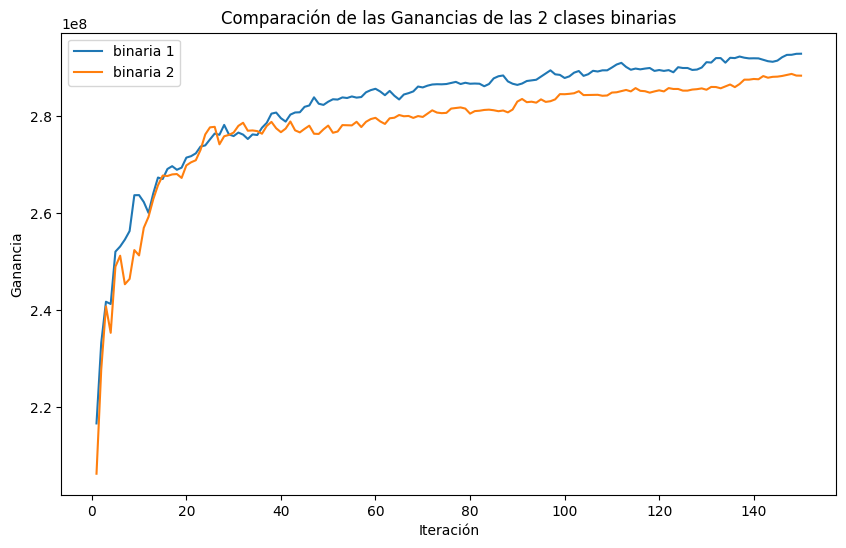

In [11]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


No parece haber un diferencia sustancial. **Pero** solo hicimos una ejecución. De tarea prueba esta estrategia correctamente.

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**. Cabe destacar que las optimizaciones que realizaremos son básicas y están diseñadas para ejecutarse en pocos minutos. Será su responsabilidad ampliar tanto el rango de búsqueda como el tiempo de optimización para obtener un modelo más competitivo.


In [12]:

def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # modificar, subit y subir... y descomentar la línea inferior
        # early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = "exp_301_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2025-10-05 15:14:40,033] A new study created in RDB with name: exp_301_lgbm


In [16]:
study.optimize(objective, n_trials=25) # subir subir

[I 2025-10-05 15:15:39,912] Trial 4 finished with value: 313200000.0 and parameters: {'num_leaves': 86, 'learning_rate': 0.04854060715966457, 'min_data_in_leaf': 700, 'feature_fraction': 0.8680148172833533, 'bagging_fraction': 0.21080356186459273}. Best is trial 4 with value: 313200000.0.
[I 2025-10-05 15:15:46,154] Trial 5 finished with value: 288880000.0 and parameters: {'num_leaves': 10, 'learning_rate': 0.2591651943593864, 'min_data_in_leaf': 368, 'feature_fraction': 0.4876577241600397, 'bagging_fraction': 0.5113374216972174}. Best is trial 4 with value: 313200000.0.
[I 2025-10-05 15:15:55,388] Trial 6 finished with value: 284460000.0 and parameters: {'num_leaves': 86, 'learning_rate': 0.008889506634842045, 'min_data_in_leaf': 908, 'feature_fraction': 0.4483655614365585, 'bagging_fraction': 0.8770467003158345}. Best is trial 4 with value: 313200000.0.
[I 2025-10-05 15:16:02,047] Trial 7 finished with value: 274880000.0 and parameters: {'num_leaves': 50, 'learning_rate': 0.157415643

Analizamos los resultados as usual

In [17]:
optuna.visualization.plot_optimization_history(study)

In [18]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [19]:
plot_slice(study)

In [20]:
plot_contour(study)

In [21]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [22]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 81


Observamos la variables más importantes para el modelo:

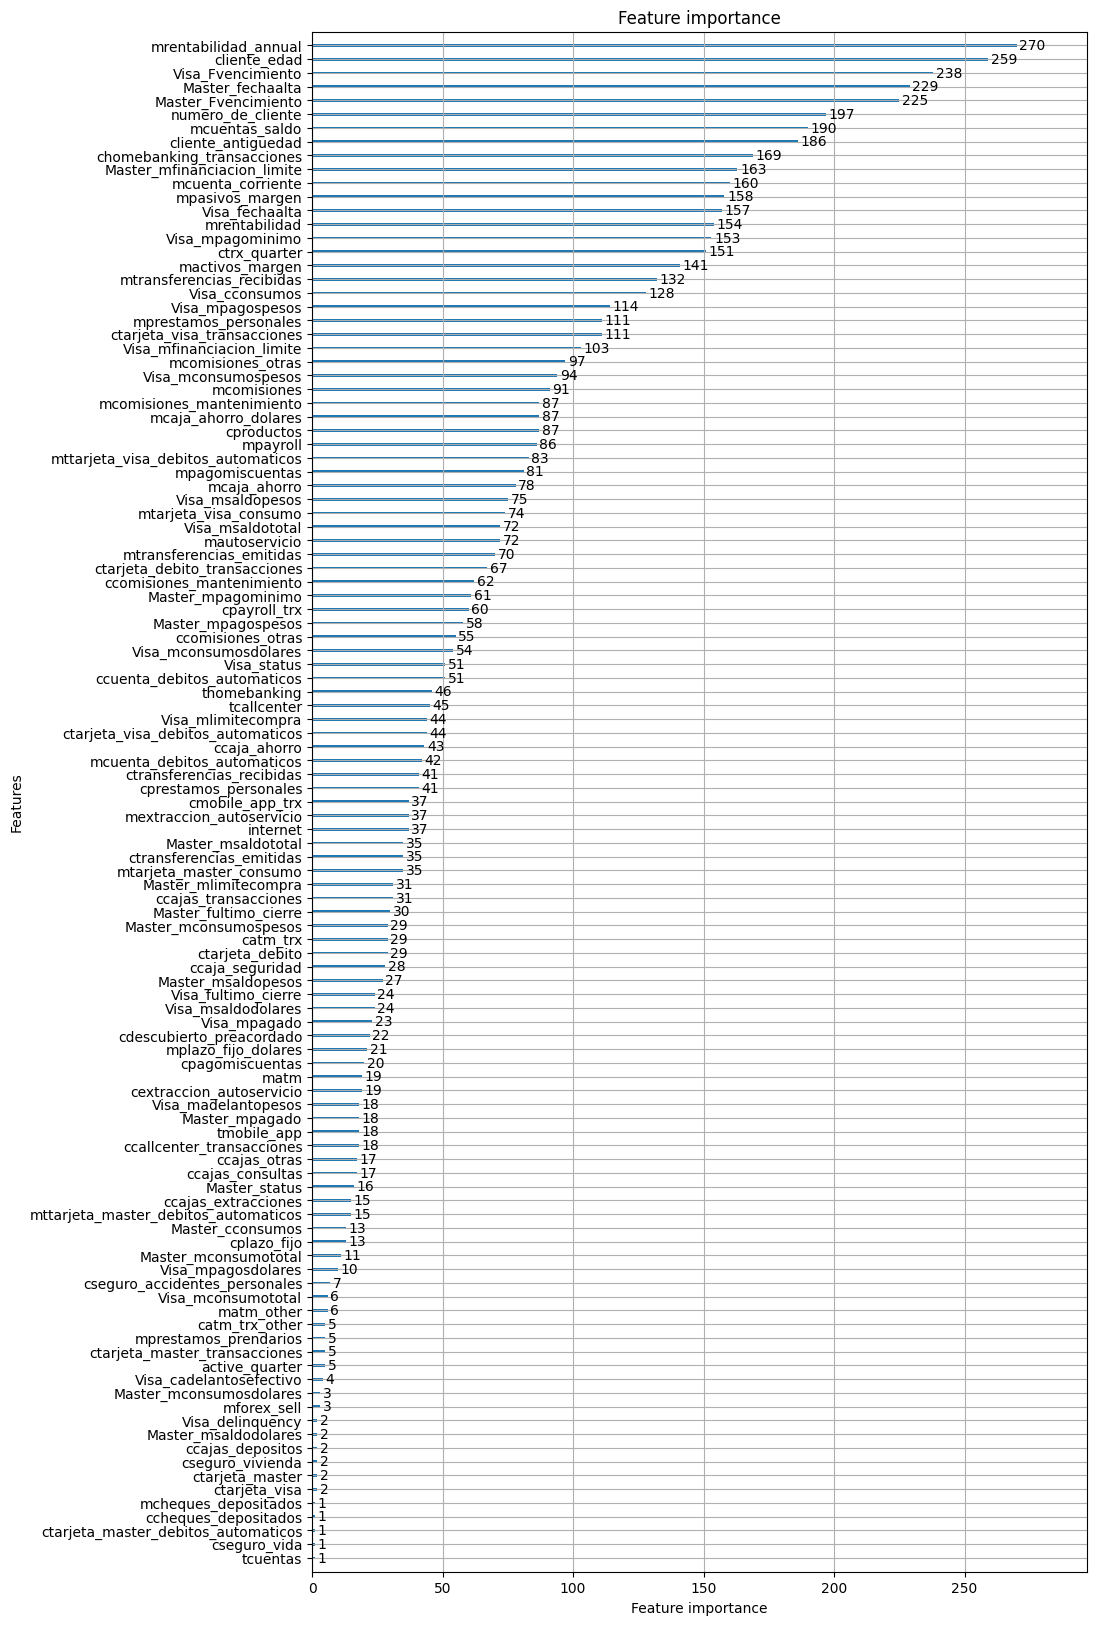

In [23]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [24]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


,feature,importance
8,mrentabilidad_annual,270
5,cliente_edad,259
135,Visa_Fvencimiento,238
127,Master_fechaalta,229
113,Master_Fvencimiento,225
...,...,...
87,mcheques_depositados,1
46,cseguro_vida,1
59,ctarjeta_master_debitos_automaticos,1
86,ccheques_depositados,1


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [26]:
model.save_model(modelos_path + 'lgb_first.txt')

Y recuperar el mismo desde ese formato

In [27]:
model = lgb.Booster(model_file=modelos_path + 'lgb_first.txt')

Para realizar nuestra habitual comparación de modelos, partiremos desde el mejor que obtuvimos hasta ahora, el **rf**. Para este fin cargaremos el *binario* que ajustamos un par de clases atrás:

In [28]:
filename_rf_1000 = modelos_path + 'exp_206_random_forest_model_1000.sav'
model_rf_1000 = pickle.load(open(filename_rf_1000, 'rb'))

Y sobre ambos modelos obtenemos la predicción de **Abril**

In [29]:
y_pred_rf = model_rf_1000.predict_proba(Xif)
y_pred_rf = y_pred_rf[:,1] # adaptamos la salida para que sea homogénea con el LGBM

y_pred_lgm = model.predict(X_test)

Finalmente medimos las ganancias de ambos

In [30]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

print("Ganancia RF:", ganancia_prob(y_pred_rf, y_test_binaria1))
print("Ganancia LGBM:", ganancia_prob(y_pred_lgm, y_test_binaria1))


Ganancia RF: 321020000.0
Ganancia LGBM: 334800000.0


Vemos un nuevo salto, tan alto como el del árbol al rf. Será simplemente suerte? veamos que sucede sobre múltiples **LDB**

In [31]:
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])
modelos = {"rf":y_pred_rf, "lgbm":y_pred_lgm}
rows = []
for private_index, public_index in sss_futuro.split(X_test, y_test_binaria1):
  row = {}
  for name, y_pred in modelos.items():
    row[name + "_public"] = ganancia_prob(y_pred[public_index], y_test_binaria1.iloc[public_index], 0.3)
    row[name + "_private"] = ganancia_prob(y_pred[private_index], y_test_binaria1.iloc[private_index], 0.7)
  rows.append(row)
df_lb = pd.DataFrame(rows)


In [32]:
df_lb_long = df_lb.reset_index()
df_lb_long = df_lb_long.melt(id_vars=['index'], var_name='model_type', value_name='ganancia')
df_lb_long[['modelo', 'tipo']] = df_lb_long['model_type'].str.split('_', expand=True)
df_lb_long = df_lb_long[['ganancia', 'tipo', 'modelo']]

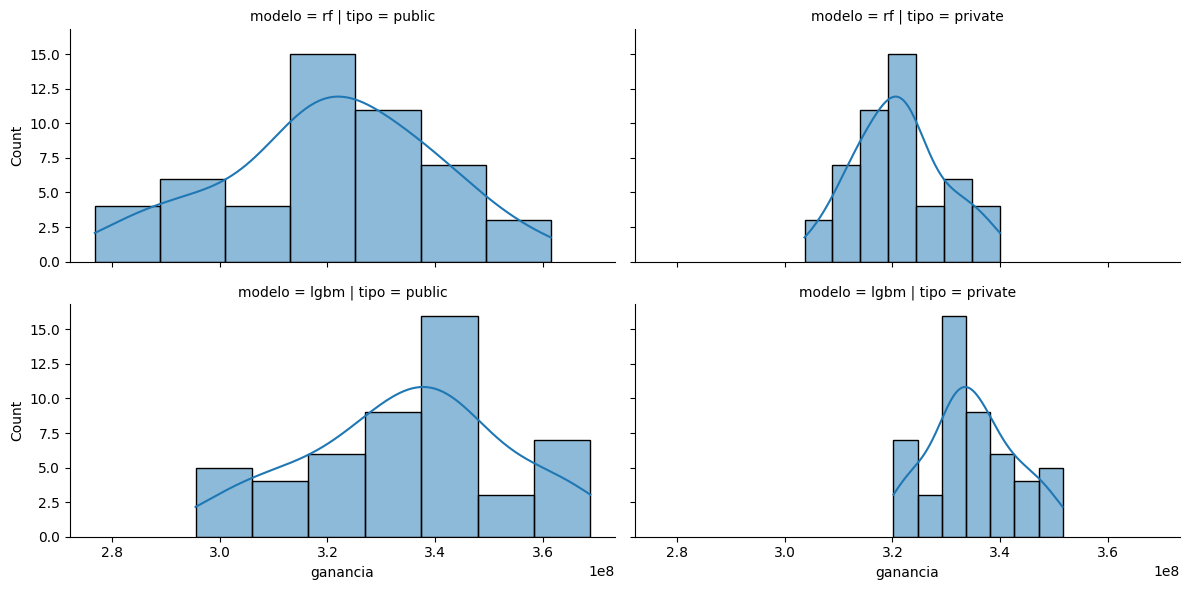

In [33]:
g = sns.FacetGrid(df_lb_long, col="tipo", row="modelo", aspect=2)
g.map(sns.histplot, "ganancia", kde=True)
plt.show()


Otra vez se observa la superioridad del **LGBM**. Veamos que hubiera pasado si elegíamos el mejor del público

In [34]:
df = pd.DataFrame()
df['best_public'] = df_lb.filter(regex='_public').idxmax(axis=1)
df['best_private'] = df_lb.filter(regex='_private').idxmax(axis=1)

pd.crosstab(df['best_public'], df['best_private'])

best_private,lgbm_private,rf_private
best_public,,
lgbm_public,41,1
rf_public,8,0


Observamos que en 50 **LDBs** solo en un público ganó un **rf**, sin embargo en el 100% de los casos, en el privado ganó un **lgbm**. Asombroso.

Pero el alumno atento, vio que para la selección del mejor modelo no se utilizó ningún punto de corte. Podrá pasar que el mejor punto de corte en entrenamiento, no sea el mejor para un mes en el futuro?

Veamos para esto la curva de ganancia en función de los puntos de corte

In [35]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


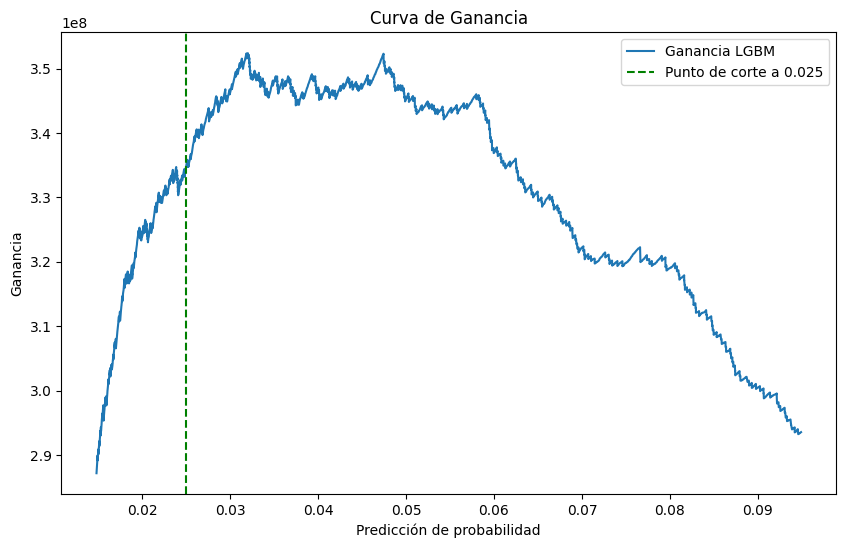

In [36]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()


Vaya! realmente nuestro teórico mejor punto de corte no es el que mayor ganancia genera. Es hora de cambiar el enfoque.

En vez de mirar el punto de corte, empezaremos a pensar en cuál es la cantidad máxima de clientes que se deben estimular. Si cambiamos a esto, veremos que el gráfico anterior se ve así

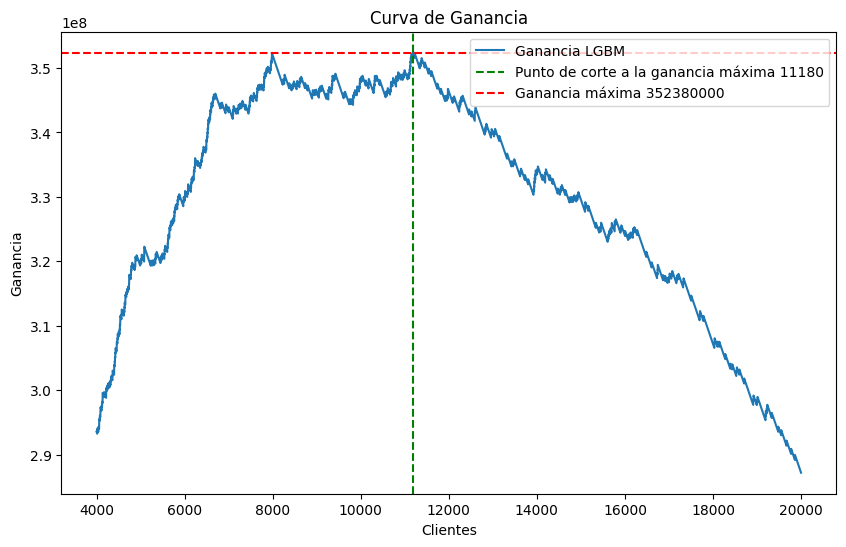

In [37]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Lo que significa que la cantidad de envíos que maximiza la ganancia es 12601.

Claro, estamos haciendo trampa. No nunca vamos a contar con datos del futuro para determinar este punto de corte.


## Tarea:

1. **Generar Dataset**  
   - Utilice las técnicas de *feature engineering* vistas en las clases anteriores para generar un nuevo conjunto de datos.
   
2. **Optimización de LightGBM (LGBM)**  
   - Ajuste el modelo de LightGBM utilizando una mayor cantidad de árboles y realice una exploración más exhaustiva de los hiperparámetros para mejorar su rendimiento.
   
3. **Incluir Nuevos Parámetros en la Optimización**  
   - Revise la documentación de los parámetros de LightGBM. Evalúe la inclusión de otros parámetros en el proceso de optimización, y ajuste el modelo con estos nuevos parámetros.
   
4. **Selección del Mejor Modelo**  
   - Entre los cinco mejores modelos obtenidos en cada optimización, seleccione el que considere más adecuado para la competencia en Kaggle.
   - Documente las pruebas que realizó para seleccionar el mejor modelo. Justifique su decisión con métricas relevantes y análisis comparativos.
5. Escriba y comparta por **Zulip** una función que envíe prepare el dataset que es necesario enviar a **kaggle** con los N clientes con mayor probabilidad.